In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

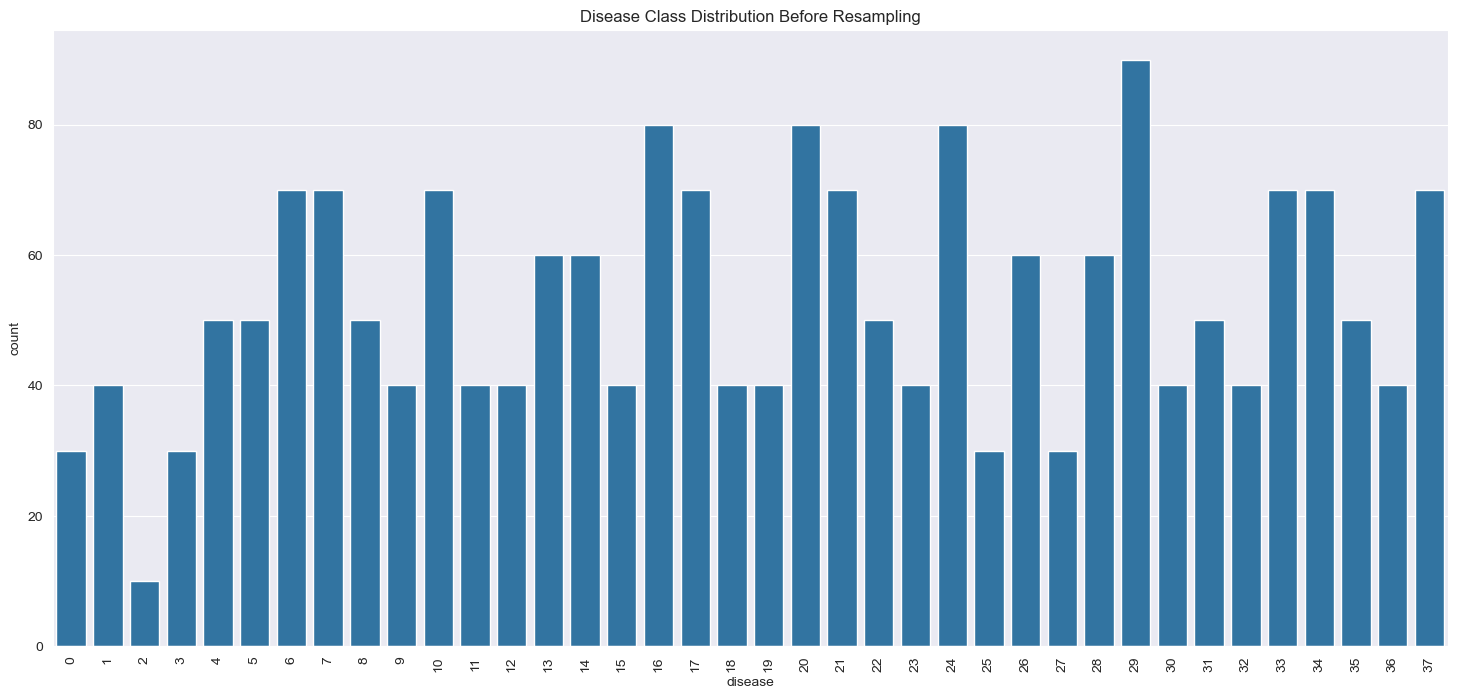

Resampled Class Distribution:
 disease
29    90
11    90
4     90
18    90
23    90
1     90
12    90
30    90
32    90
9     90
20    90
36    90
15    90
19    90
27    90
3     90
25    90
0     90
5     90
22    90
35    90
31    90
16    90
24    90
7     90
17    90
34    90
10    90
37    90
6     90
33    90
21    90
26    90
13    90
28    90
14    90
8     90
2     90
Name: count, dtype: int64


In [4]:
from imblearn.over_sampling import RandomOverSampler


data = pd.read_csv('improved_disease_dataset.csv')

encoder = LabelEncoder()
data["disease"] = encoder.fit_transform(data["disease"])

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

plt.figure(figsize=(18, 8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation=90)
plt.show()

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Resampled Class Distribution:\n", pd.Series(y_resampled).value_counts())

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder


if 'gender' in X_resampled.columns:
    le = LabelEncoder()
    X_resampled['gender'] = le.fit_transform(X_resampled['gender'])

X_resampled = X_resampled.fillna(0)

if len(y_resampled.shape) > 1:
    y_resampled = y_resampled.values.ravel()

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

cv_scoring = 'accuracy'  # you can also use 'f1_weighted', 'roc_auc_ovr' for multi-class
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    try:
        scores = cross_val_score(
            model,
            X_resampled,
            y_resampled,
            cv=stratified_kfold,
            scoring=cv_scoring,
            n_jobs=-1,
            error_score='raise'
        )
        print("=" * 50)
        print(f"Model: {model_name}")
        print(f"Scores: {scores}")
        print(f"Mean Accuracy: {scores.mean():.4f}")
    except Exception as e:
        print("=" * 50)
        print(f"Model: {model_name} failed with error:")
        print(e)

Model: Decision Tree
Scores: [0.5497076  0.54532164 0.5380117  0.53654971 0.52923977]
Mean Accuracy: 0.5398
Model: Random Forest
Scores: [0.5497076  0.56140351 0.53947368 0.55409357 0.5248538 ]
Mean Accuracy: 0.5459


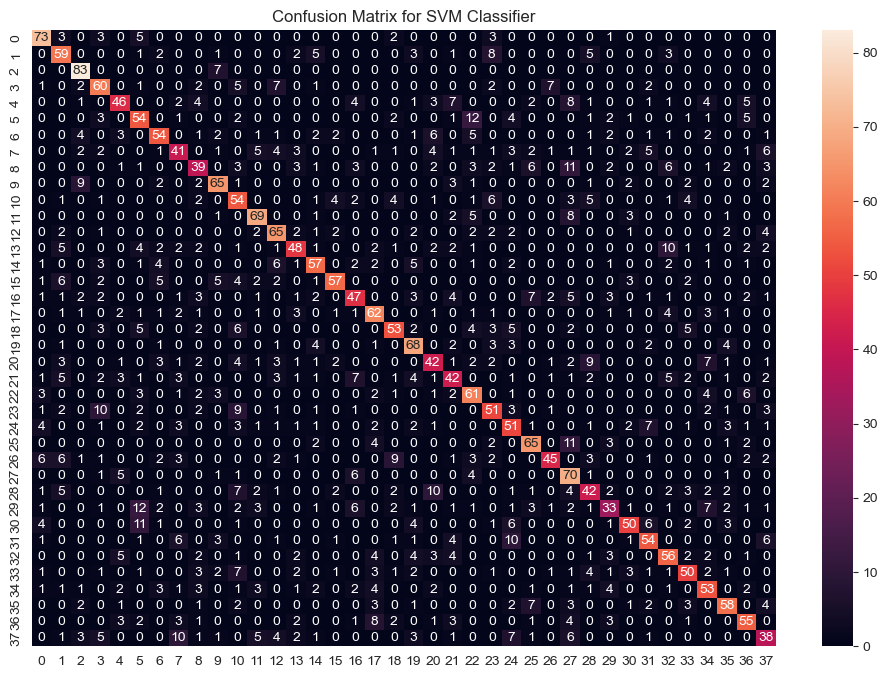

SVM Accuracy: 60.53%


In [8]:
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)
svm_preds = svm_model.predict(X_resampled)

cf_matrix_svm = confusion_matrix(y_resampled, svm_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_svm, annot=True, fmt="d")
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

print(f"SVM Accuracy: {accuracy_score(y_resampled, svm_preds) * 100:.2f}%")

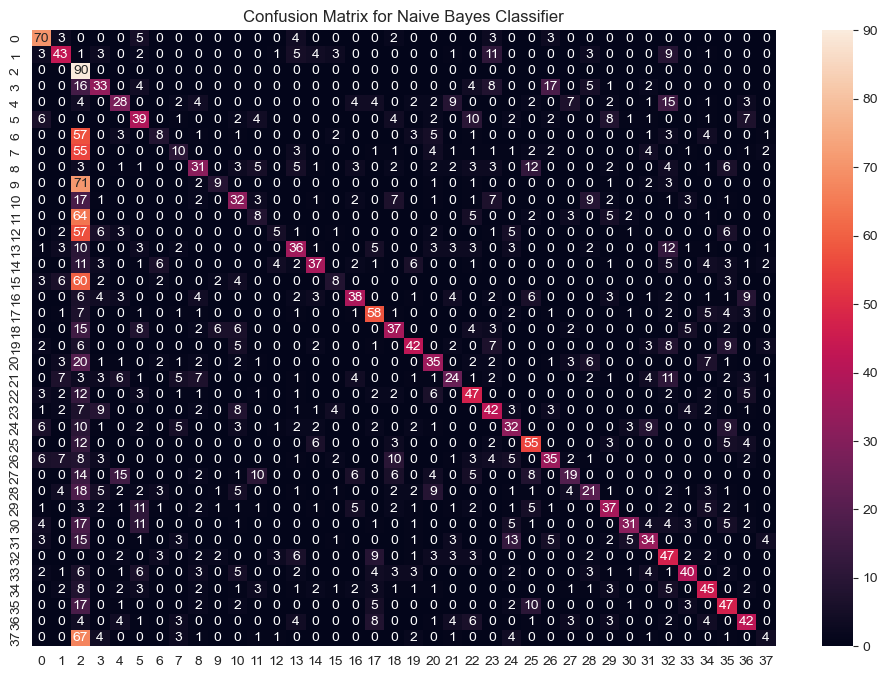

Naive Bayes Accuracy: 37.98%


In [9]:
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
nb_preds = nb_model.predict(X_resampled)

cf_matrix_nb = confusion_matrix(y_resampled, nb_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_nb, annot=True, fmt="d")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

print(f"Naive Bayes Accuracy: {accuracy_score(y_resampled, nb_preds) * 100:.2f}%")

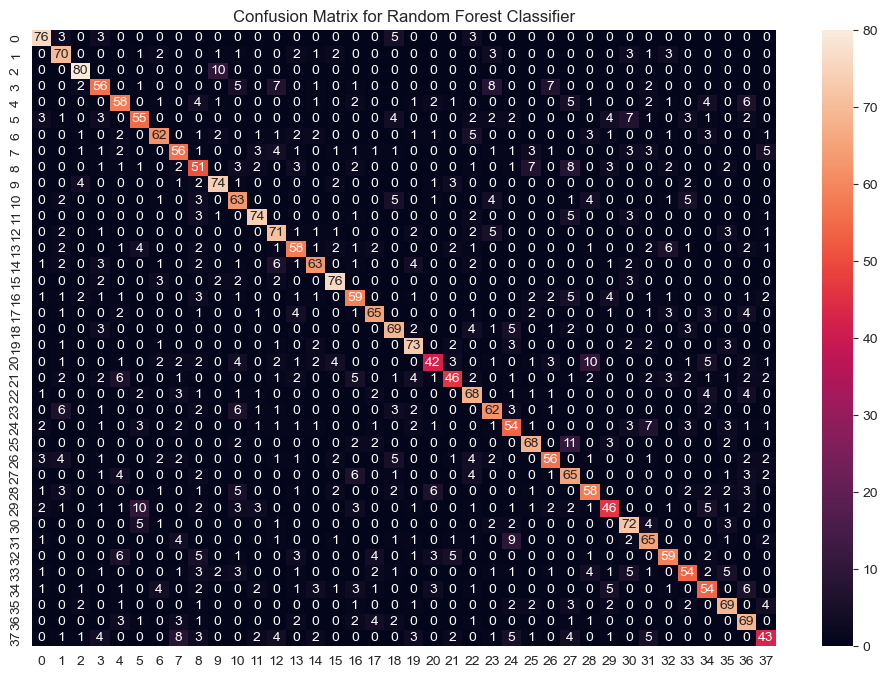

Random Forest Accuracy: 68.98%


In [10]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
rf_preds = rf_model.predict(X_resampled)

cf_matrix_rf = confusion_matrix(y_resampled, rf_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_rf, annot=True, fmt="d")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

print(f"Random Forest Accuracy: {accuracy_score(y_resampled, rf_preds) * 100:.2f}%")

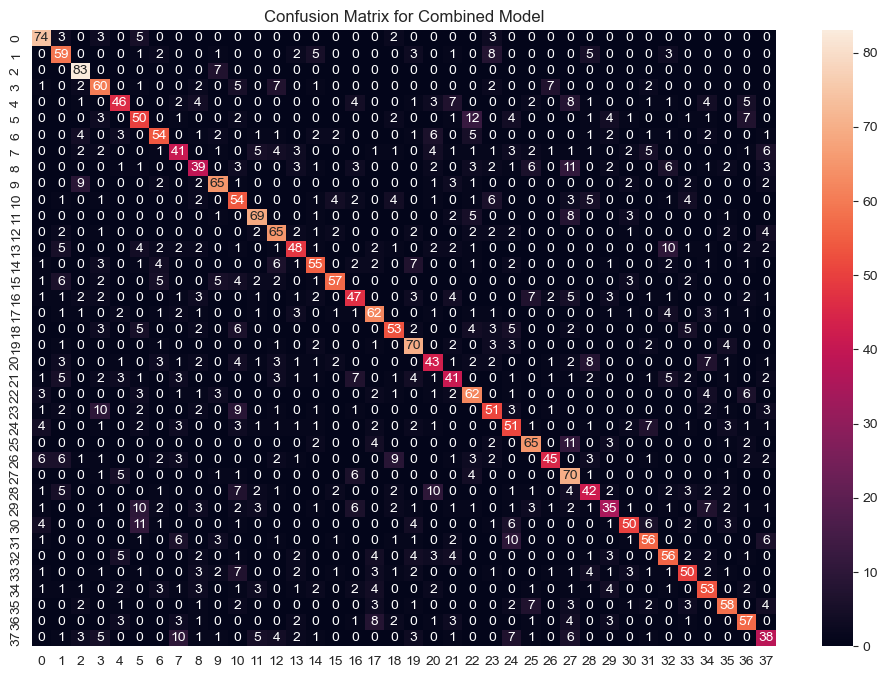

Combined Model Accuracy: 60.64%


In [11]:
from statistics import mode

final_preds = [mode([i, j, k]) for i, j, k in zip(svm_preds, nb_preds, rf_preds)]

cf_matrix_combined = confusion_matrix(y_resampled, final_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_combined, annot=True, fmt="d")
plt.title("Confusion Matrix for Combined Model")
plt.show()

print(f"Combined Model Accuracy: {accuracy_score(y_resampled, final_preds) * 100:.2f}%")

In [17]:
symptoms = X.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

def predict_disease(input_symptoms):
    input_symptoms = input_symptoms.split(",")
    input_data = [0] * len(symptom_index)

    for symptom in input_symptoms:
        if symptom in symptom_index:
            input_data[symptom_index[symptom]] = 1

    input_data = np.array(input_data).reshape(1, -1)

    rf_pred = encoder.classes_[rf_model.predict(input_data)[0]]
    nb_pred = encoder.classes_[nb_model.predict(input_data)[0]]
    svm_pred = encoder.classes_[svm_model.predict(input_data)[0]]

    final_pred = mode([rf_pred, nb_pred, svm_pred])

    return {
        "Random Forest Prediction": rf_pred,
        "Naive Bayes Prediction": nb_pred,
        "SVM Prediction": svm_pred,
        "Final Prediction": final_pred
    }

print(predict_disease("Itching,Skin Rash,Nodal Skin Eruptions"))

{'Random Forest Prediction': 'Heart attack', 'Naive Bayes Prediction': 'Urinary tract infection', 'SVM Prediction': 'Impetigo', 'Final Prediction': 'Heart attack'}


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
